<a href="https://colab.research.google.com/github/udbhav-chugh/TextCoherenceOnSocialMedia/blob/master/Text_Coherence_Pre_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This notebook contains code for data pre-processing and vector embedding generation as described in the report.


*   This notebook directly imports the social media and NTSB testing and training data from Kaggle
*   Importing GloVE embeddings is done from Google Drive 
*   The following pre-processing steps are followed:
  * Sentence Level Cleaning: Removing non-alphanumeric characters
  * Word/Token Level Cleaning: Stem each word + remove stop words
  * Genism simple_preprocess
  * LDA based Topic Modelling
  * GloVE embeddings generation for each sentence 
* Output: Word embeddings for training and testing of NTSB and social media corpus
* A sample of generated embeddings is also included at the end of the Colab sheet
* Note: Cells can take in excess of an hour to complete and can overload RAM so run relevant cells only




In [ ]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim pre-processing
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Import Dataset from Kaggle for Social Media Corpus
!echo '{"username":"cs565textcoherence","key":"f6241b25f4d4b4bb68bbab249d91bbd3"}' > /root/.kaggle/kaggle.json
%cd /content/
!kaggle datasets download -d cs565textcoherence/dataset-postncomments-combined
!kaggle datasets download -d cs565textcoherence/dataset-postncomments-separate
!unzip \*.zip  && rm *.zip

df_combined = pd.read_csv('/content/datasetPostsAndCommentsCombined.tsv',sep="\t")
df_separate = pd.read_csv('/content/datasetPostsAndCommentsSeparate.tsv',sep="\t")

# print(df.columns[0])
# print(df.columns[1])
df_combined.head(10)
# df_combined['Jumbled_Post'].head(10)

,Original_Post,Jumbled_Post
0,I decided to post this partially because I'm i...,This is my secret. I'm reading every single co...
1,I decided to post this partially because I'm i...,I hope you like your dirty laundry aired. Chee...
2,I decided to post this partially because I'm i...,Fuck. fucking. awesome.So I'm assuming you're ...
3,I decided to post this partially because I'm i...,ft. bunker on the property that I built about ...
4,I decided to post this partially because I'm i...,A lot of you seem to be contemplating suicide ...
5,I decided to post this partially because I'm i...,Fuck. The sort of things that make you questio...
6,I decided to post this partially because I'm i...,You're all a part of Reddit history right here...
7,I decided to post this partially because I'm i...,A lot of you seem to be contemplating suicide ...
8,I decided to post this partially because I'm i...,Surely I can't be alone. Cheers everyone.Two a...
9,I decided to post this partially because I'm i...,ft. bunker on the property that I built about ...


In [ ]:
# Import Dataset from Kaggle for NTSB training data
!echo '{"username":"cs565textcoherence","key":"f6241b25f4d4b4bb68bbab249d91bbd3"}' > /root/.kaggle/kaggle.json
%cd /content/
!kaggle datasets download -d cs565textcoherence/ntsb-aviation-accident-report-dataset
!unzip \*.zip  && rm *.zip

df_combined = pd.read_csv('/content/datasetTestingAccidents.tsv',sep="\t")
df_separate = pd.read_csv('/content/datasetTrainingAccidents.tsv',sep="\t")

# print(df.columns[0])
# print(df.columns[1])
df_combined.head(10)
# df_combined['Jumbled_Post'].head(10)

/content
  0% 0.00/302k [00:00<?, ?B/s]
100% 302k/302k [00:00<00:00, 45.0MB/s]
Archive:  ntsb-aviation-accident-report-dataset.zip
replace datasetTestingAccidents.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: datasetTestingAccidents.tsv  
replace datasetTrainingAccidents.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: datasetTrainingAccidents.tsv  


,Original_Post,Jumbled_Post
0,"This is preliminary information, subject to ch...","The flight had originated at Henderson, Nevada..."
1,"This is preliminary information, subject to ch...",An on-scene examination revealed engine oil co...
2,"This is preliminary information, subject to ch...",En route the pilot experienced engine vibratio...
3,"This is preliminary information, subject to ch...",Visual meteorological conditions prevailed for...
4,"This is preliminary information, subject to ch...","The private pilot, the sole occupant, was not ..."
5,"This is preliminary information, subject to ch...",Any errors in this report will be corrected wh...
6,"This is preliminary information, subject to ch...",A post accident examination of the engine reve...
7,"This is preliminary information, subject to ch...",Further examination revealed an oil filter gas...
8,"This is preliminary information, subject to ch...",A post accident examination of the engine reve...
9,"This is preliminary information, subject to ch...",A post accident examination of the engine reve...


In [ ]:
# Sentence tokenize for both training and testing data of poth dataset types
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

df_combined['Original_Post_Sentences'] = df_combined.apply(lambda row: sent_tokenize(row.Original_Post), axis = 1) 
df_combined['Jumbled_Post_Sentences'] = df_combined.apply(lambda row: sent_tokenize(row.Jumbled_Post), axis = 1) 
df_separate['Original_Post_Sentences'] = df_separate.apply(lambda row: sent_tokenize(row.Original_Post), axis = 1) 
df_separate['Jumbled_Post_Sentences'] = df_separate.apply(lambda row: sent_tokenize(row.Jumbled_Post), axis = 1) 

# df_combined.head()
# df_separate.head()
print(df_separate['Original_Post_Sentences'][20])
print(df_separate['Jumbled_Post_Sentences'][20])



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['Earlier on the day of the accident, the airplane was being operated on the ground, when the main landing gear was inadvertently retracted.', 'The airplane settled on its tail; however, the propellers did not touch the ground.', 'The engines were shut down, and the occupants deplaned.', 'The airplane was raised, and the gear was extended.', 'The airplane was inspected, which included removal of the side and rear panels in the vicinity of the stabilator and rudder.', 'A ferry permit was issued for flight to another airport where repairs could be made, with the restriction that the landing gear remain extended.', 'The pilot departed on the flight, and after takeoff, he requested to return for a landing with no reason given.', 'The airplane was observed to turn crosswind and then downwind, where it subsequently descended in a wings level attitude below the level of surrounding t

In [ ]:
# Sentence and word level cleaning of tokens with PorterStemmer

import re
from nltk.stem import PorterStemmer


def sent_to_words(sent_list, stop_words=stop_words):
  words_total = []
  for sentence in sent_list:
    sentence = re.sub('\S*@\S*\s?', '', sentence)  # remove emails
    sentence = re.sub('\s+', ' ', sentence)  # remove newline chars
    sentence = re.sub("\'", "", sentence)  # remove single quotes
    words_sent = []
    words = [word for word in simple_preprocess(sentence, deacc=True) if word not in stop_words] 
    # nlp = spacy.load('en', disable=['parser', 'ner'])
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    words = [word for word in simple_preprocess(sentence, deacc=True) if word not in stop_words] 
    words_total.append(words)

  return words_total


df_combined['Original_Post_Words'] = df_combined.apply(lambda row: sent_to_words(row.Original_Post_Sentences), axis = 1) 
df_combined['Jumbled_Post_Words'] = df_combined.apply(lambda row: sent_to_words(row.Jumbled_Post_Sentences), axis = 1) 
df_separate['Original_Post_Words'] = df_separate.apply(lambda row: sent_to_words(row.Original_Post_Sentences), axis = 1) 
df_separate['Jumbled_Post_Words'] = df_separate.apply(lambda row: sent_to_words(row.Jumbled_Post_Sentences), axis = 1) 

# df_combined.head()
# print(df_combined['Original_Post_Words'][0])

# for post in combined_org_word[:6]:
#   print(post)
# for post in combined_jumbled_word[:6]:
#   print(post)

    

In [ ]:
# Create Dictionary for Own Corpus
words_list = []
# print(df_combined['Original_Post_Words'].values.tolist())
for post in df_combined['Original_Post_Words'].values.tolist():
  for sentence in post:
    for word in sentence:
      # print(word)
      words_list.append(word)

bigram = gensim.models.Phrases(words_list, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [[bigram_mod[sentences] for sentences in post] for post in texts]

combined_original_bigrams = make_bigrams(df_combined['Original_Post_Words'].values.tolist())
combined_jumbled_bigrams = make_bigrams(df_combined['Jumbled_Post_Words'].values.tolist())
separate_original_bigrams = make_bigrams(df_separate['Original_Post_Words'].values.tolist())
separate_jumbled_bigrams = make_bigrams(df_separate['Jumbled_Post_Words'].values.tolist())

print(combined_original_bigrams[:10])
# print(combined_jumbled_bigrams[:1])
print(separate_original_bigrams[:10])
# print(separate_jumbled_bigrams[:1])


# Lemmatization of posts for LDA topic modelling
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    # for post in texts:
    for sent in texts[0]:
        # for words in sent:
      doc = nlp(" ".join(sent)) 
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# nlp = spacy.load('en', disable=['parser', 'ner'])
# combined_original_lemmatized = lemmatization(combined_original_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# separate_original_lemmatized = lemmatization(separate_original_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# print(combined_original_lemmatized[:10])
# print(separate_original_lemmatized[:10])




[[['preliminary', 'information', 'change', 'contain', 'errors'], ['errors', 'report', 'corrected', 'final', 'report', 'completed'], ['january', 'central', 'standard', 'time', 'bell', 'helicopter', 'registered', 'reeder', 'flying', 'service', 'operated', 'helicopteros', 'sa', 'experienced', 'hard', 'landing', 'near', 'neacon', 'nicaragua', 'executive', 'flight', 'mining', 'area'], ['visual', 'meteorological', 'conditions', 'prevailed', 'flight', 'plan', 'filed', 'local', 'flight'], ['helicopter', 'substantially', 'damaged', 'pilot', 'four', 'passengers', 'reported', 'injuries'], ['flight', 'originated', 'unknown', 'time', 'unknown', 'location'], ['initial', 'information', 'nicaraguan', 'aviation', 'authorities', 'final', 'approach', 'engine', 'failed', 'helicopter', 'landed', 'hard'], ['report', 'filed', 'information', 'purposes', 'contains', 'information', 'provided', 'nicaraguan', 'aviation', 'authorities'], ['additional', 'information', 'contact', 'director', 'general', 'civil', 'avi

In [ ]:
# Importing benchmark evaluation content
! rm -rf web
! cp -r '/content/drive/My Drive/web' .

import logging
from web.embeddings import fetch_GloVe

# Fetch GloVE pre-trained embeddings of 50 dimension
w_glove = fetch_GloVe(corpus="wiki-6B", dim=50)
print(w_glove['reddit'])

File already downloaded, skipping
[-0.05838835 -0.11331697 -0.03556503  0.1638772  -0.15215546  0.07571654
 -0.30215287 -0.06950356  0.10433258 -0.05164835  0.05257746 -0.02633757
  0.22546405 -0.12261032  0.02584235 -0.0759119  -0.21182275  0.01836883
  0.21732697  0.0099812   0.0445199  -0.06816328 -0.01172333  0.19336328
  0.2505181   0.22237459  0.09731089  0.01465467 -0.12859613 -0.08513027
 -0.10495728  0.0368576  -0.00885491 -0.14808011 -0.26208085  0.0780518
  0.041017   -0.10325354 -0.0063127   0.014149    0.08777448 -0.14817551
 -0.33988503  0.00206346  0.18992627 -0.15261433 -0.05389956  0.07575061
  0.35194752 -0.01168653]


In [ ]:
import pickle

with open("/content/combined_original_lemmatized.txt", "wb") as fp:   #Pickling
  pickle.dump(combined_original_lemmatized, fp)
with open("/content/separate_original_lemmatized.txt", "wb") as fp:   #Pickling
  pickle.dump(separate_original_lemmatized, fp)
with open("/content/combined_original_lemmatized.txt", "rb") as fp:   # Unpickling
  combined_original_lemmatized = pickle.load(fp)
with open("/content/separate_original_lemmatized.txt", "rb") as fp:   # Unpickling
  separate_original_lemmatized = pickle.load(fp)
print(combined_original_lemmatized[:5])


id2word = corpora.Dictionary(combined_original_lemmatized)

texts = combined_original_lemmatized

# Create Corpus: Term Document Frequency
lda_corpus = [id2word.doc2bow(text) for text in texts]

# LDA Topic Modelling
lda_model =  gensim.models.LdaMulticore(corpus = lda_corpus, 
                                   num_topics = 10, 
                                   id2word = id2word,                                    
                                   passes = 10,
                                   alpha = 'symmetric',
                                  iterations = 100,
                                   workers = 8)

pprint(lda_model.print_topics())

[(0,
  '0.037*"have" + 0.035*"be" + 0.022*"awesome" + 0.021*"keep" + 0.020*"home" + '
  '0.020*"sell" + 0.020*"thing" + 0.020*"comment" + 0.020*"s" + 0.020*"edit"'),
 (1,
  '0.045*"be" + 0.043*"man" + 0.019*"hide" + 0.019*"single" + 0.018*"bunker" + '
  '0.018*"much" + 0.018*"situation" + 0.018*"somewhere" + 0.018*"love" + '
  '0.018*"pic"')]


In [ ]:
import numpy as np
import random
random.seed(10)
num1 = len(combined_original_bigrams)//(80)
print(num1)
cmbnd_ind1 = random.sample(range(num1), num1//10)
print(cmbnd_ind1)

combined_train_embeddings = []
combined_test_embeddings = []

# Generate word embeddings
def func(bigrams):
  post_embedding = []
  for sentence in bigrams:
    sent_embedding = []
    for word in sentence:
      if (word in w_glove):
        # sent_embedding.append(w_glove[word])
        sent_embedding.append(word)
    sent_embedding = np.array(sent_embedding)
    if (len(sent_embedding) != 0):
      post_embedding.append(sent_embedding)
  return post_embedding

def funcM():
  # print(len(combined_original_bigrams))
  for i in range(0, len(combined_original_bigrams), 20):
    # post_embedding = []
    # for sentence in combined_original_bigrams[i]:
    #   sent_embedding = []
    #   for word in sentence:
    #     if (word in w_glove):
    #       sent_embedding.append(w_glove[word])
    #       # sent_embedding.append(word)
    #   sent_embedding = np.array(sent_embedding)
    #   if (len(sent_embedding) != 0):
    #     post_embedding.append(sent_embedding)
    # if ((i//20)%num1 not in cmbnd_ind1):
    combined_train_embeddings.append((func(combined_original_bigrams[i]), 1))
    combined_train_embeddings.append((func(combined_jumbled_bigrams[i]), 0))
    
    # if ((i//20)%num1 not in cmbnd_ind1):
    #   combined_train_embeddings.append(post_embedding)
    # else:
    #   for j in range(0,20):
    #     # print(i+j)
    #     combined_test_embeddings.append((func(combined_original_bigrams[i+j]), func(combined_jumbled_bigrams[i+j])))
    #   # combined_test_embeddings.append(post_embedding)

funcM()


# random.shuffle(combined_train_embeddings)


print(combined_original_bigrams[0])
print(combined_jumbled_bigrams[0])
print(len(combined_test_embeddings))
print(len(combined_train_embeddings))

print(combined_train_embeddings[0])
print(combined_train_embeddings[4])
print(combined_train_embeddings[8])
# print(combined_train_embeddings[20])



import pickle
# Tranferring embeddings into files
with open("/content/combined_test_embeddings.txt", "wb") as fp:   #Pickling
  pickle.dump(combined_test_embeddings, fp)
with open("/content/combined_train_embeddings.txt", "wb") as fp:   #Pickling
  pickle.dump(combined_train_embeddings, fp)
with open("/content/combined_test_embeddings.txt", "rb") as fp:   # Unpickling
  combined_test_embeddings = pickle.load(fp)
with open("/content/combined_train_embeddings.txt", "rb") as fp:   # Unpickling
  combined_train_embeddings = pickle.load(fp)

for postx(post[1])

for post in combined_test_embeddings:
  for sentence in post[0]:
    # print(len(sentence))
    print(len(sentence[0]))
    print(sentence[0])
    # sentence has the sentence embedding
  for sentence in post[1]:
    # print(len(sentence))
    print(len(sentence[0]))
    print(sentence[0])
    # sentence has the sentence embedding
        

25
[18, 1]
200
([array(['preliminary', 'information', 'change', 'contain', 'errors'],
      dtype='<U11'), array(['errors', 'report', 'corrected', 'final', 'report', 'completed'],
      dtype='<U9'), array(['january', 'central', 'standard', 'time', 'bell', 'helicopter',
       'registered', 'reeder', 'flying', 'service', 'operated', 'sa',
       'experienced', 'hard', 'landing', 'near', 'nicaragua', 'executive',
       'flight', 'mining', 'area'], dtype='<U11'), array(['visual', 'meteorological', 'conditions', 'prevailed', 'flight',
       'plan', 'filed', 'local', 'flight'], dtype='<U14'), array(['helicopter', 'substantially', 'damaged', 'pilot', 'four',
       'passengers', 'reported', 'injuries'], dtype='<U13'), array(['flight', 'originated', 'unknown', 'time', 'unknown', 'location'],
      dtype='<U10'), array(['initial', 'information', 'nicaraguan', 'aviation', 'authorities',
       'final', 'approach', 'engine', 'failed', 'helicopter', 'landed',
       'hard'], dtype='<U11'), arr

In [ ]:
import numpy as np
import random
random.seed(10)
num1 = len(separate_original_bigrams)//(80)
# print(num1)
cmbnd_ind1 = random.sample(range(num1), num1//10)
print(cmbnd_ind1)

separate_train_embeddings = []
separate_test_embeddings = []

# Generate word embeddings
def func(bigrams):
  post_embedding = []
  for sentence in bigrams:
    sent_embedding = []
    for word in sentence:
      if (word in w_glove):
        sent_embedding.append(w_glove[word])
        # sent_embedding.append(word)
    sent_embedding = np.array(sent_embedding)
    if (len(sent_embedding) != 0):
      post_embedding.append(sent_embedding)
  return post_embedding

def funcM():
  # print(len(separate_original_bigrams))
  for i in range(0, len(separate_original_bigrams), 20):
    post_embedding = []
    for sentence in separate_original_bigrams[i]:
      sent_embedding = []
      for word in sentence:
        if (word in w_glove):
          sent_embedding.append(w_glove[word])
          # sent_embedding.append(word)
      sent_embedding = np.array(sent_embedding)
      if (len(sent_embedding) != 0):
        post_embedding.append(sent_embedding)
    if ((i//20)%num1 not in cmbnd_ind1):
      separate_train_embeddings.append(post_embedding)
    else:
      for j in range(0,20):
        # print(i+j)
        separate_test_embeddings.append((func(separate_original_bigrams[i+j]), func(separate_jumbled_bigrams[i+j])))
      # separate_test_embeddings.append(post_embedding)
    for j in range(0,20):
      # print(i+j)
      separate_test_embeddings.append((func(separate_original_bigrams[i+j]), func(separate_jumbled_bigrams[i+j])))
    # if ((i//20)%num1 not in cmbnd_ind1):
    #   separate_train_embeddings.append((func(separate_original_bigrams[i]), 1))
    #   separate_train_embeddings.append((func(separate_jumbled_bigrams[i]), 0))
    

funcM()

random.shuffle(separate_train_embeddings)


print(separate_original_bigrams[20])
print(separate_jumbled_bigrams[20])
print(len(separate_test_embeddings))
print(len(separate_train_embeddings))

print(separate_train_embeddings[0])
print(separate_train_embeddings[1])
print(separate_train_embeddings[19])
print(separate_train_embeddings[20])



import pickle
# Tranferring embeddings into files

with open("/content/separate_test_embeddings.txt", "wb") as fp:   #Pickling
  pickle.dump(separate_test_embeddings, fp)
with open("/content/separate_train_embeddings.txt", "wb") as fp:   #Pickling
  pickle.dump(separate_train_embeddings, fp)
with open("/content/separate_test_embeddings.txt", "rb") as fp:   # Unpickling
  separate_test_embeddings = pickle.load(fp)
with open("/content/separate_train_embeddings.txt", "rb") as fp:   # Unpickling
  separate_train_embeddings = pickle.load(fp)



for post in separate_train_embeddings:
  for sentence in post[0]:
    # print(len(sentence))
    print(len(sentence[0]))
    print(sentence[0])
    # sentence has the sentence embedding
  print(post[1])

for post in separate_test_embeddings:
  for sentence in post[0]:
    # print(len(sentence))
    print(len(sentence[0]))
    print(sentence[0])
    # sentence has the sentence embedding
  for sentence in post[1]:
    # print(len(sentence))
    print(len(sentence[0]))
    print(sentence[0])
    # sentence has the sentence embedding
        

Streaming output truncated to the last 5000 lines.
 -0.13122313 -0.2615639   0.13990404  0.08699857 -0.03400843 -0.07426463
  0.6251553  -0.08112291 -0.02830434 -0.04943176 -0.00080724 -0.01977003
  0.11431806  0.08435152  0.02241531  0.07181142 -0.03408196 -0.09012245
 -0.00879678 -0.09627441 -0.0056143   0.02916664 -0.04237964 -0.21943827
  0.06407747 -0.11309925]
50
[-0.05838835 -0.11331697 -0.03556503  0.1638772  -0.15215546  0.07571654
 -0.30215287 -0.06950356  0.10433258 -0.05164835  0.05257746 -0.02633757
  0.22546405 -0.12261032  0.02584235 -0.0759119  -0.21182275  0.01836883
  0.21732697  0.0099812   0.0445199  -0.06816328 -0.01172333  0.19336328
  0.2505181   0.22237459  0.09731089  0.01465467 -0.12859613 -0.08513027
 -0.10495728  0.0368576  -0.00885491 -0.14808011 -0.26208085  0.0780518
  0.041017   -0.10325354 -0.0063127   0.014149    0.08777448 -0.14817551
 -0.33988503  0.00206346  0.18992627 -0.15261433 -0.05389956  0.07575061
  0.35194752 -0.01168653]
50
[-0.16480418  0.

In [ ]:
# Find main topics in LDA modelling and report them
def format_topics_sentences(ldamodel=lda_model, corpus=lda_corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=lda_corpus, texts=texts)

# # Format
# df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# df_dominant_topic.head(10)
# print(df_dominant_topic['Text'][0])

In [ ]:
# df_topic_sents_keywords = format_topics_sentences()

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)
# print(df_dominant_topic['Text'][1])

# entity_list = []
# for entities in df_dominant_topic['Text']:
#   entity_list.append(entities)

# print(entity_list[:2])

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9496,"have, be, awesome, keep, home, sell, thing, co...","[decide, partially, be, interested, reaction, ..."
1,1,0.0,0.8939,"have, be, awesome, keep, home, sell, thing, co...","[thing, question, sanity, worth]"
2,2,0.0,0.8659,"have, be, awesome, keep, home, sell, thing, co...","[surely, can, alone]"
3,3,0.0,0.8243,"have, be, awesome, keep, home, sell, thing, co...","[comment, upvote]"
4,4,1.0,0.8907,"be, man, hide, single, bunker, much, situation...","[be, part, reddit, history]"
5,5,0.0,0.8205,"have, be, awesome, keep, home, sell, thing, co...","[thank, contribution]"
6,6,0.0,0.8259,"have, be, awesome, keep, home, sell, thing, co...","[have, make]"
7,7,0.0,0.7403,"have, be, awesome, keep, home, sell, thing, co...",[secret]
8,8,0.0,0.5000,"have, be, awesome, keep, home, sell, thing, co...",[]
9,9,0.0,0.8675,"have, be, awesome, keep, home, sell, thing, co...","[edit, front, page]"


In [ ]:
#Word2Vec embeddings generation
from nltk.tokenize import sent_tokenize, word_tokenize 
import warnings 
  
warnings.filterwarnings(action = 'ignore') 
  
import gensim 
from gensim.models import Word2Vec 

import nltk
nltk.download('punkt')

In [ ]:
model1 = gensim.models.Word2Vec(data, min_count = 1,  
                              size = 100, window = 5)  #size is the number of dimensions


In [ ]:
from gensim.models import KeyedVectors
filename = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# Embedding list for Word2Vec
embedding_list = []

for entities in entity_list:
  embeddings = []
  for entity in entities:
    if (entity in model):
      embeddings.append(model[entity])
  embedding_list.append(embeddings)

print(embedding_list[1][1])
  
print(model.similarity("man", "king"))
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)
    

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('queen', 0.7118192911148071)]


In [ ]:
#Google pre-trained Word2Vec embeddings generation --> Not used in current implementation
import gensim

filename = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
model1 = gensim.models.KeyedVectors.load_word2vec_format(filename, binary=True)


In [ ]:
# Keys to generate embeddings for in 2D space
keys = ['explosive', 'organization', 'sanity', 'cheat', 'car', 'time', 'book', 'dinner', 'woman', 'home', 'lawyer']

#keys = ['Universe',"Religion","Funny","Tasty","phone","peace","money"]
#keys = ['terror']
import random
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model1.most_similar(word, topn=5):
        words.append(similar_word)
        embeddings.append(model1[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
#print(word_clusters[0])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

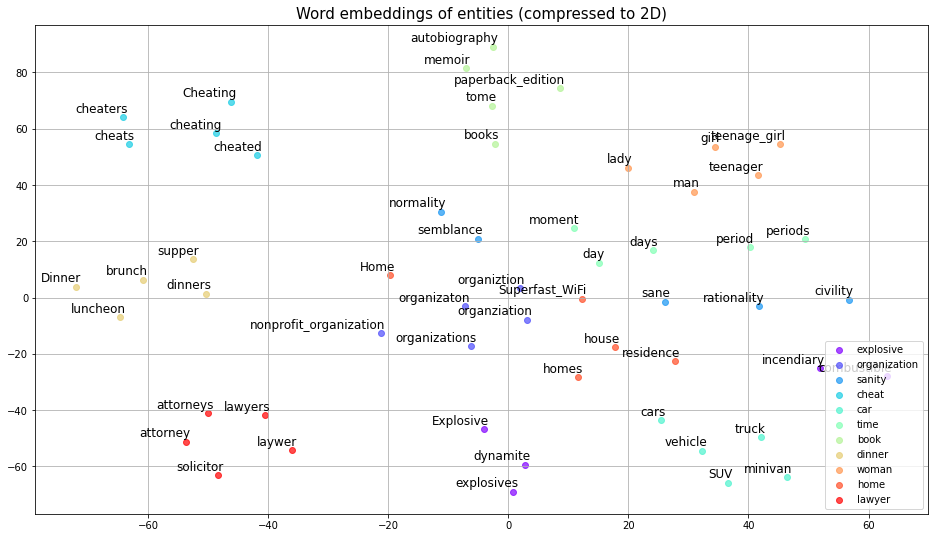

In [ ]:
# Generating embeddings mapped in 2D space 
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
% matplotlib inline


def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16,9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=2, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=12)
    plt.legend(loc=4)
    plt.title('Word embeddings of entities (compressed to 2D)', fontsize=15)
    plt.grid(True)
    plt.savefig("/content/output.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(keys, embeddings_en_2d, word_clusters)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
